In [27]:
import keras
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from scipy.stats import percentileofscore, rankdata
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import pickle as pkl
from functools import partial
from tqdm import tqdm_notebook

sns.set_style("darkgrid")
%matplotlib inline

In [2]:
DATA_PATH = "../Cardiac_muscle/"
MARKS = ["H3K4me3", "H3K9me3", "H3K36me3", "H3K27me3", "H3K27ac", "H3K4me1"]
SIZE = "100"
state = 100

## Model

In [7]:
def get_autoencoder(inside, optimizer, loss):
    input_img = Input(shape=(6,))
    encoded = Dense(4, activation=inside)(input_img)
    encoded = Dense(2, activation=inside)(encoded)
    decoded = Dense(4, activation=inside)(encoded)
    decoded = Dense(6, activation='sigmoid')(decoded)
    deep_autoencoder = Model(input_img, decoded)
    deep_autoencoder.compile(optimizer=optimizer, loss=loss) 
    encoder = Model(input_img, encoded)
    return deep_autoencoder, encoder

In [8]:
insides = ["sigmoid", "relu"]
optimizers = ["adadelta", "adam", "nadam", "adamax", "adagrad"]

In [9]:
autoencoder_dict = dict()
for inside in insides:
    for optimizer in optimizers:
        autoencoder_dict[(inside, optimizer)] = get_autoencoder(inside, optimizer, "mse")

In [10]:
autoencoder_dict[("sigmoid", "nadam")][0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 6)                 0         
_________________________________________________________________
dense_69 (Dense)             (None, 4)                 28        
_________________________________________________________________
dense_70 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_71 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_72 (Dense)             (None, 6)                 30        
Total params: 80
Trainable params: 80
Non-trainable params: 0
_________________________________________________________________


## Dataset

In [11]:
first_chrom = dict()
for mark in MARKS:
    with open("{}{}_100.pkl".format(DATA_PATH, mark), "rb") as mark_file:
        first_chrom[mark] = pkl.load(mark_file)

In [12]:
for mark in first_chrom:
    where_nans = np.isnan(first_chrom[mark])
    first_chrom[mark][where_nans] = 0

In [ ]:
first_chrom_df = pd.DataFrame(first_chrom)
first_chrom_scaled = pd.DataFrame(scale(first_chrom_df), columns=first_chrom_df.columns)

In [14]:
# first_nonzero = first_chrom_df[first_chrom_df.apply(sum, axis=1) != 0]
first_nonzero = pd.read_hdf("../Cardiac_muscle/first_nonzero.hdf")

In [16]:
first_nonzero.to_hdf("../Cardiac_muscle/first_nonzero.hdf", "w")

In [17]:
genes = pd.read_hdf("../Labels/ensembl_CDSs.hdf")
labels_nonzero = genes[first_nonzero.index]
labels_nonzero.index = range(len(labels_nonzero))

In [18]:
first_nonzero.head()

,H3K27ac,H3K27me3,H3K36me3,H3K4me1,H3K4me3,H3K9me3
98,0.000000,0.000000,0.000000,0.000000,0.000000,0.032607
99,0.134452,0.071357,0.150166,0.000000,0.178754,0.166953
100,0.409484,0.331994,0.257893,0.010391,0.527132,0.828330
101,1.106421,0.888328,0.233954,0.135092,0.825033,2.003630
102,1.508669,1.465509,0.462926,0.490447,1.117832,2.107487


In [19]:
len(first_nonzero)

2206482

In [20]:
def get_quant(column, row):
    return percentileofscore(first_chrom_scaled[column], row[column])

In [21]:
quant_scaled = pd.DataFrame()
for column in tqdm_notebook(first_nonzero.columns):
    print(column)
    quant_scaled[column] = rankdata(first_nonzero[column], method="average") / len(first_nonzero)
#     quantilize = partial(get_quant, column)
#     quant_scaled[column] = first_chrom_scaled.apply(quantilize, axis=1)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

H3K27ac
H3K27me3
H3K36me3
H3K4me1
H3K4me3
H3K9me3



In [22]:
x_train, x_test = train_test_split(quant_scaled, test_size=0.2, random_state=state)

In [23]:
x_train.head()

,H3K27ac,H3K27me3,H3K36me3,H3K4me1,H3K4me3,H3K9me3
1453965,0.571852,0.915979,0.801637,0.313480,0.846220,0.992860
1915671,0.691489,0.829418,0.880634,0.477877,0.550437,0.919766
1660602,0.916550,0.292676,0.737345,0.948688,0.466556,0.816524
470680,0.754725,0.992119,0.422752,0.422723,0.574312,0.613865
442690,0.542691,0.046222,0.934821,0.428091,0.952296,0.609962


## Train dat shit

In [ ]:
dim_dict = dict()
for key, (autoencoder, encoder) in autoencoder_dict.items():
    autoencoder.fit(x_train, x_train,
                    epochs=20,
                    batch_size=256,
                    shuffle=True,
                    validation_data=(x_test, x_test))
    dim_dict[key] = zip(*encoder.predict(quant_scaled))

In [24]:
autoencoder_dict[("sigmoid", "nadam")][0].fit(x_train.values, x_train.values,
                                              epochs=100,
                                              batch_size=256,
                                              shuffle=True,
                                              validation_data=(x_test, x_test))

Train on 1765185 samples, validate on 441297 samples
Epoch 1/100
1765185/1765185 [==============================] - 9s 5us/step - loss: 0.0457 - val_loss: 0.0384
Epoch 2/100
1765185/1765185 [==============================] - 8s 5us/step - loss: 0.0383 - val_loss: 0.0381
Epoch 3/100
1765185/1765185 [==============================] - 8s 5us/step - loss: 0.0382 - val_loss: 0.0381
Epoch 4/100
1765185/1765185 [==============================] - 8s 5us/step - loss: 0.0381 - val_loss: 0.0381
Epoch 5/100
1765185/1765185 [==============================] - 8s 5us/step - loss: 0.0381 - val_loss: 0.0381
Epoch 6/100
1765185/1765185 [==============================] - 8s 5us/step - loss: 0.0380 - val_loss: 0.0379
Epoch 7/100
1765185/1765185 [==============================] - 8s 5us/step - loss: 0.0376 - val_loss: 0.0369
Epoch 8/100
1765185/1765185 [==============================] - 8s 5us/step - loss: 0.0363 - val_loss: 0.0359
Epoch 9/100
1765185/1765185 [==============================] - 8s 5us/step 

1765185/1765185 [==============================] - 8s 5us/step - loss: 0.0341 - val_loss: 0.0340
Epoch 76/100
1765185/1765185 [==============================] - 8s 5us/step - loss: 0.0341 - val_loss: 0.0341
Epoch 77/100
1765185/1765185 [==============================] - 8s 4us/step - loss: 0.0341 - val_loss: 0.0340
Epoch 78/100
1765185/1765185 [==============================] - 8s 4us/step - loss: 0.0341 - val_loss: 0.0340
Epoch 79/100
1765185/1765185 [==============================] - 8s 5us/step - loss: 0.0341 - val_loss: 0.0340
Epoch 80/100
1765185/1765185 [==============================] - 8s 5us/step - loss: 0.0341 - val_loss: 0.0340
Epoch 81/100
1765185/1765185 [==============================] - 8s 5us/step - loss: 0.0341 - val_loss: 0.0340
Epoch 82/100
1765185/1765185 [==============================] - 8s 5us/step - loss: 0.0341 - val_loss: 0.0340
Epoch 83/100
1765185/1765185 [==============================] - 8s 5us/step - loss: 0.0341 - val_loss: 0.0340
Epoch 84/100
1765185/17

In [25]:
x, y = zip(*autoencoder_dict[("sigmoid", "nadam")][1].predict(quant_scaled))

In [29]:
auto_df = pd.DataFrame({"x": x, "y": y})

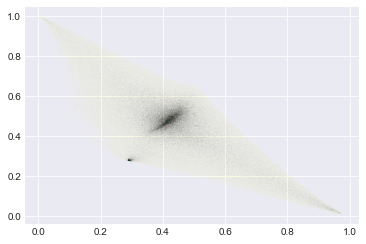

In [38]:
plt.scatter(x, y, alpha=0.007, s=0.1, c=labels_nonzero, cmap="YlGn")

## PCA stuff

In [28]:
pca = PCA(n_components=2)

In [34]:
auto_pca_arr = pca.fit_transform(auto_df)
auto_pca_df = pd.DataFrame(auto_pca_arr, columns=["x", "y"])

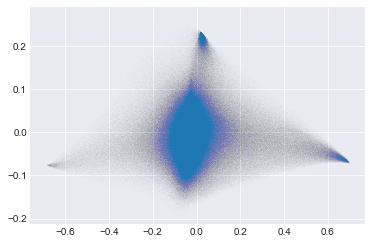

In [35]:
plt.scatter(auto_pca_df["x"], auto_pca_df["y"], alpha=0.007, s=0.1)

## TSNE stuff

In [61]:
x, y = dim_dict[("sigmoid", "nadam")]

In [84]:
first_nonzero["auto_x"] = x
first_nonzero["auto_y"] = y

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [87]:
first_nonzero_scaled = pd.DataFrame(scale(first_nonzero), columns=first_nonzero.columns)

In [88]:
first_nonzero_scaled.to_hdf("../Models/first_nonzero_scaled.hdf", key="w")

In [89]:
def lol_sum(row):
    return sum(row[:-2])

In [47]:
first_nonzero = first_chrom_df[first_chrom_df.apply(lol_sum, axis=1) != 0]
first_nonzero_scaled = pd.DataFrame(scale(first_nonzero), columns=first_chrom_df.columns)

In [39]:
little_all_scaled = first_scaled_all.sample(n=6000, random_state=state)

In [98]:
little_nonzero_scaled = first_nonzero_scaled.sample(n=6000, random_state=state)

In [99]:
tsne = TSNE(random_state=state)

In [100]:
lol_table = tsne.fit_transform(little_nonzero_scaled)

In [101]:
lol_x, lol_y = zip(*lol_table)

In [ ]:
plt.scatter(x, y, alpha=1)

In [45]:
first_chrom_df.head()

,H3K27ac,H3K27me3,H3K36me3,H3K4me1,H3K4me3,H3K9me3
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
labels_nonzero[labels_nonzero == 0] = -1

In [54]:
sum(labels_nonzero) / len(labels_nonzero)

-0.9192660533827152

In [ ]:
plt.scatter(x, y, alpha=0.1, s=0.2, c=labels_nonzero, cmap="binary")

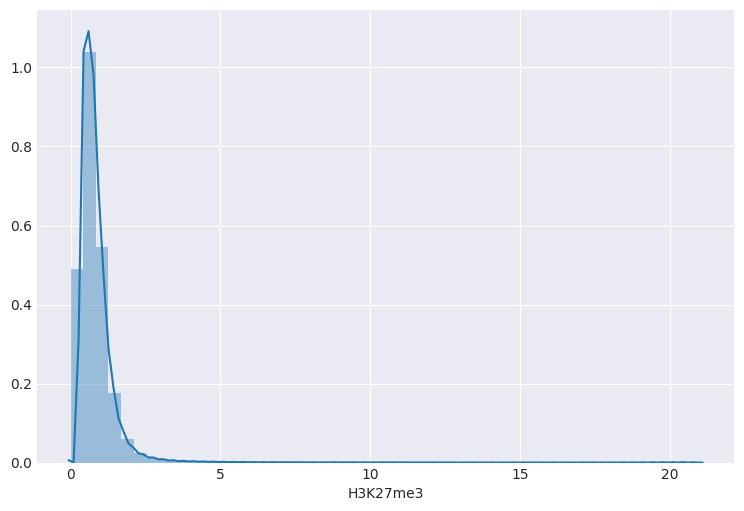

In [104]:
sns.distplot(first_nonzero["H3K27me3"])

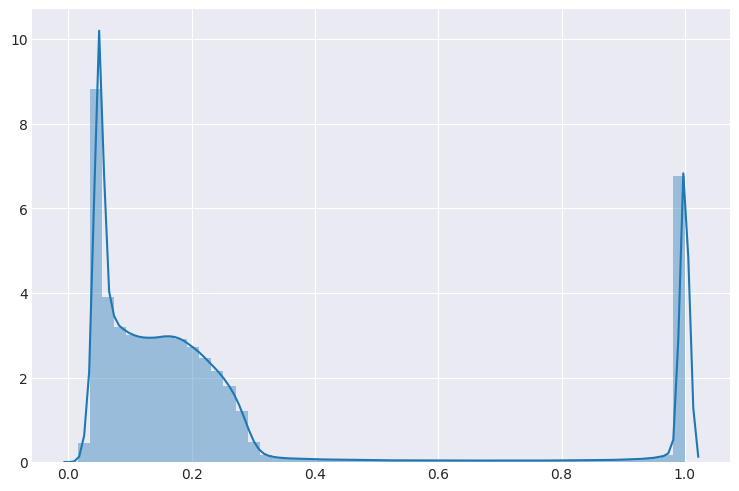

In [67]:
sns.distplot(x)

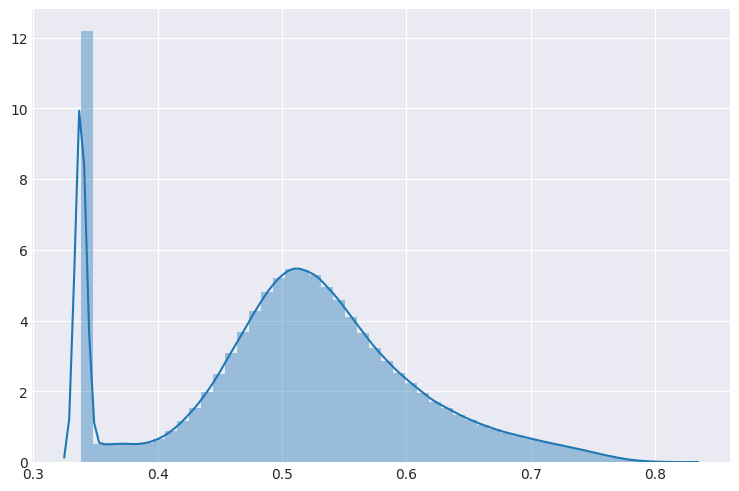

In [68]:
sns.distplot(y)

## Cluster like I dunno what

In [8]:
from scipy import optimize
from sklearn.metrics import mean_squared_error
from sklearn.o

In [10]:
import sklearn as sk

In [14]:
from sklearn import calibration as cal

In [13]:
sk.__all__

['calibration',
 'cluster',
 'covariance',
 'cross_decomposition',
 'cross_validation',
 'datasets',
 'decomposition',
 'dummy',
 'ensemble',
 'exceptions',
 'externals',
 'feature_extraction',
 'feature_selection',
 'gaussian_process',
 'grid_search',
 'isotonic',
 'kernel_approximation',
 'kernel_ridge',
 'learning_curve',
 'linear_model',
 'manifold',
 'metrics',
 'mixture',
 'model_selection',
 'multiclass',
 'multioutput',
 'naive_bayes',
 'neighbors',
 'neural_network',
 'pipeline',
 'preprocessing',
 'random_projection',
 'semi_supervised',
 'svm',
 'tree',
 'discriminant_analysis',
 'clone']

In [12]:
dir(sk)

['_ASSUME_FINITE',
 '__SKLEARN_SETUP__',
 '__all__',
 '__builtins__',
 '__cached__',
 '__check_build',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_contextmanager',
 'base',
 'clone',
 'config_context',
 'exceptions',
 'externals',
 'get_config',
 'logger',
 'logging',
 'metrics',
 'os',
 'preprocessing',
 're',
 'set_config',
 'setup_module',
 'sys',
 'utils',
 'warnings']

In [5]:
dir(optimize)

['LbfgsInvHessProduct',
 'OptimizeResult',
 'OptimizeWarning',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_basinhopping',
 '_cobyla',
 '_differentialevolution',
 '_group_columns',
 '_hungarian',
 '_lbfgsb',
 '_linprog',
 '_linprog_ip',
 '_lsq',
 '_minimize',
 '_minpack',
 '_nnls',
 '_numdiff',
 '_remove_redundancy',
 '_root',
 '_slsqp',
 '_spectral',
 '_trlib',
 '_trustregion',
 '_trustregion_dogleg',
 '_trustregion_exact',
 '_trustregion_krylov',
 '_trustregion_ncg',
 '_zeros',
 'absolute_import',
 'anderson',
 'approx_fprime',
 'basinhopping',
 'bisect',
 'bracket',
 'brent',
 'brenth',
 'brentq',
 'broyden1',
 'broyden2',
 'brute',
 'check_grad',
 'cobyla',
 'curve_fit',
 'diagbroyden',
 'differential_evolution',
 'division',
 'excitingmixing',
 'fixed_point',
 'fmin',
 'fmin_bfgs',
 'fmin_cg',
 'fmin_cobyla',
 'fmin_l_bfgs_b',
 'fmin_ncg',
 'fmin_powell',
 'fmin_slsqp',
 'fmin_tnc',
 '